Found 1156 images belonging to 9 classes.
Found 502 images belonging to 9 classes.
Found 1156 files belonging to 9 classes.
Found 502 files belonging to 9 classes.
['Ajwa', 'Galaxy', 'Mejdool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_33 (Rescaling)    (None, 250, 250, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 125, 125, 16)      0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 125, 125, 32)      4640      
                                                           

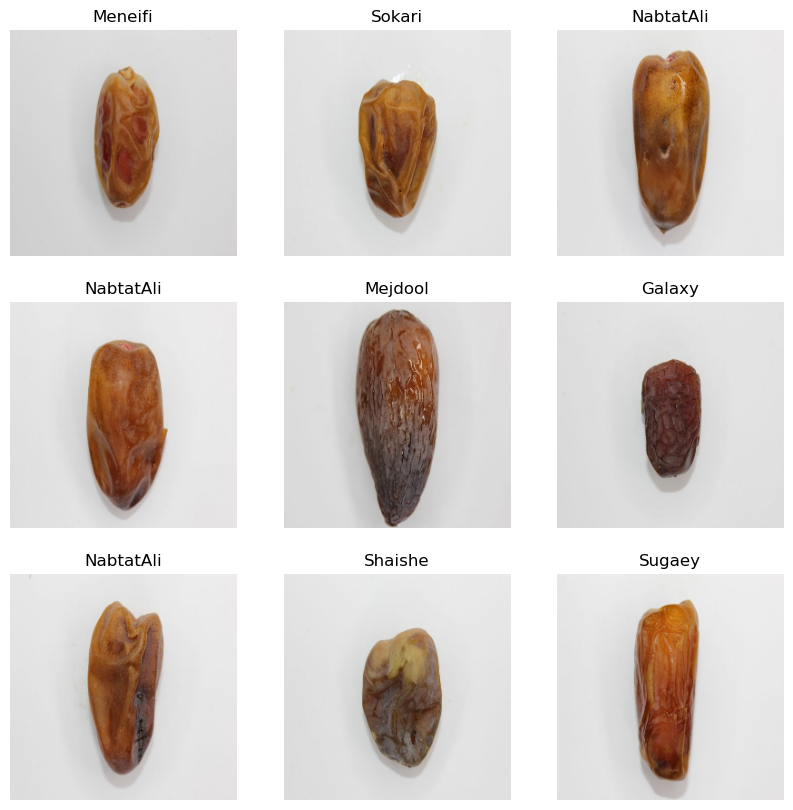

16/16 [==============================] - 1s 57ms/step
Classification Report:
              precision    recall  f1-score   support

        Ajwa       0.95      1.00      0.97        53
      Galaxy       0.84      0.86      0.85        57
     Mejdool       0.95      0.88      0.91        41
     Meneifi       0.83      0.86      0.85        70
   NabtatAli       0.85      0.87      0.86        54
       Rutab       0.92      0.80      0.85        44
     Shaishe       0.91      0.98      0.94        52
      Sokari       0.94      0.80      0.86        80
      Sugaey       0.77      0.92      0.84        51

    accuracy                           0.88       502
   macro avg       0.89      0.88      0.88       502
weighted avg       0.88      0.88      0.88       502

Confusion Matrix:
[[53  0  0  0  0  0  0  0  0]
 [ 1 49  0  4  0  0  1  1  1]
 [ 0  0 36  3  0  0  0  0  2]
 [ 2  0  0 60  1  2  0  2  3]
 [ 0  0  1  0 47  0  0  1  5]
 [ 0  0  0  2  4 35  0  0  3]
 [ 0  1  0  0  0  0 

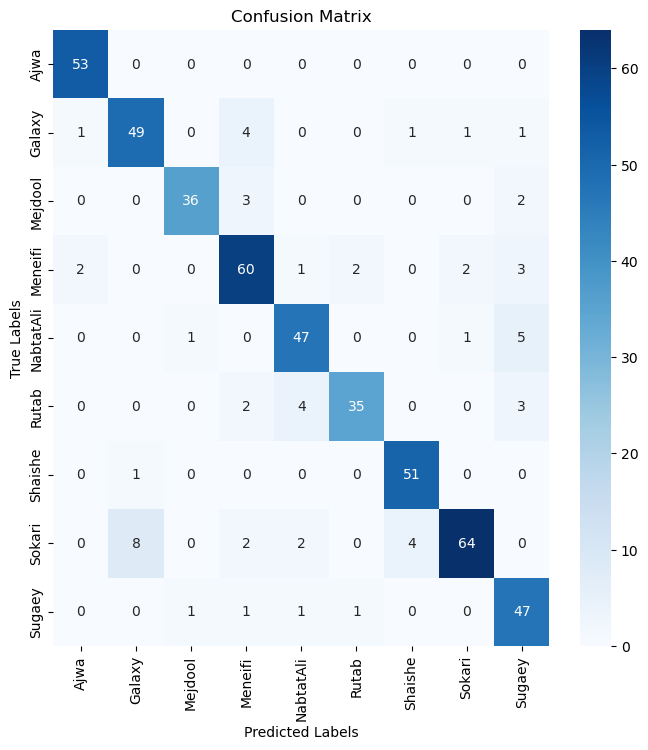

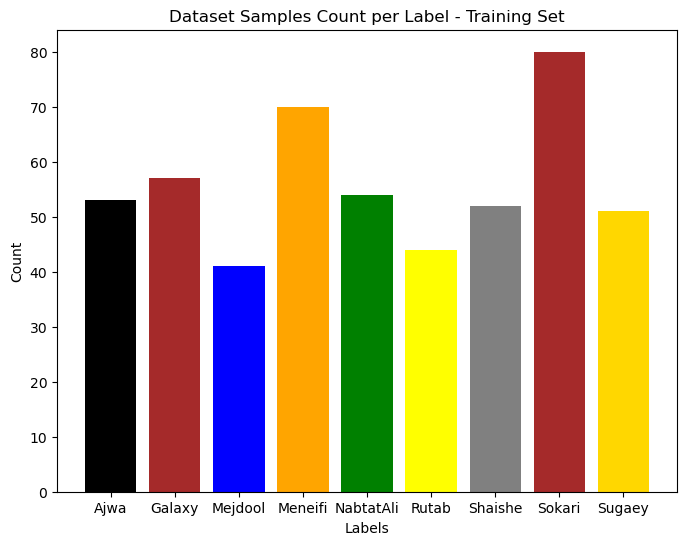

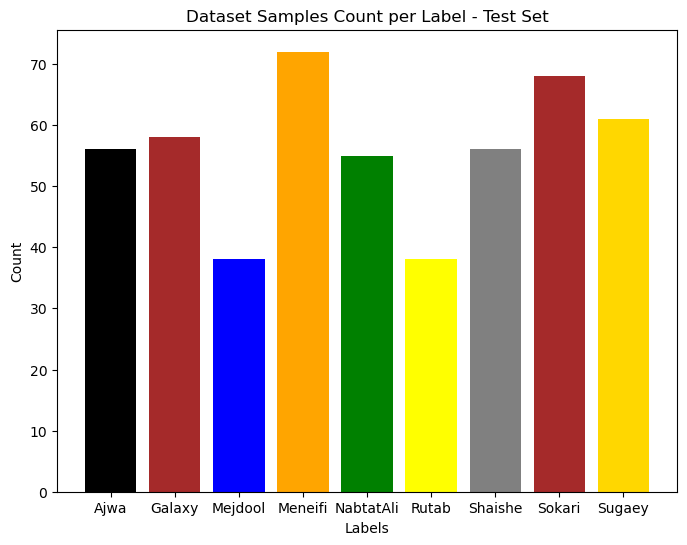

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

IMAGE_SHAPE = (250, 250)
batch_size = 30
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
train_d = 'train'
training_image_data = image_generator.flow_from_directory(train_d, target_size=IMAGE_SHAPE)

test_d = 'test'
testing_image_data = image_generator.flow_from_directory(test_d, target_size=IMAGE_SHAPE)

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_d,
    image_size=IMAGE_SHAPE,
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_SHAPE[0], IMAGE_SHAPE[1], 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

test_images, test_labels = [], []
for images, labels in test_ds:
    test_images.extend(images.numpy())
    test_labels.extend(labels.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels, target_names=class_names))

print("Confusion Matrix:")
cm = confusion_matrix(test_labels, predicted_labels)
print(cm)

accuracy = np.sum(test_labels == predicted_labels) / len(test_labels)
print("Accuracy:", accuracy)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

c = ['black', 'brown', 'blue', 'orange', 'green', 'yellow', 'grey', 'brown', 'gold']

plt.figure(figsize=(8, 6))
train_labels_count = [len(np.where(test_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, train_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Training Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
test_labels_count = [len(np.where(predicted_labels == i)[0]) for i in range(num_classes)]
plt.bar(class_names, test_labels_count, color = c)
plt.title("Dataset Samples Count per Label - Test Set")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.show()